### 目前效果还比较差，合理怀疑是每个参数组合没有充分训练的缘故

#### 引入库

In [1]:
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import matplotlib.pyplot as plt

from bayes_opt import BayesianOptimization

#### 参数设置
目前遇到了一些不会改bug，只能在cpu上跑

In [2]:
n_epochs = 3          #每个超参数组合的学习次数

batch_size_train = 100 #训练时的批次大小，根据拟合程度和硬件性能调整。太大过拟合，占用内存大，训练速度慢；太小易受噪声影响，易陷入局部最小值
batch_size_test = 50   #测试时的批次大小，调整没啥影响，一般和训练批次大小相似
#learning_rate = 1e-3   #学习率，控制参数调整幅度。太大不稳定，可能跳过全局最小值；太小收敛速度慢，易陷入局部最小值
log_interval = 100     #日志输出间隔，控制输出训练信息频率

init_points = 2 #初始探索点数量
n_iter = 10 #迭代次数
total_epoch = init_points + n_iter

pbounds = { 'learning_rate_log': (-5, -1),  
            'beta1': (0.9, 0.999), #控制一阶矩（梯度的指数加权平均）的衰减速度,其实我也不知道这是啥
            'beta2': (0.9, 0.999), #控制二阶矩（梯度平方的指数加权平均）的衰减速度,但是它总有存在的意义
            'weight_decay_log': (-5,-3) } #正则化项

random_seed = 1 #随机种子，用于复现结果
torch.manual_seed(random_seed) #设置随机种子

torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
#使用确定性算法确保结果可复现

# 检查是否有可用的CUDA
if torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")
    
device = torch.device("cpu")

#### 导入MNIST数据集  
自动下载到根目录下的 ./data/ 路径

数据集保存在 train_loader 和 test_loader 中
每张图片的灰度值 tensor 位于 train_loader.dataset.data 和 train_loader.dataset.data 中 
数量分别为 6w 和 1w

每张图片的 tensor 
dtype=torch.uint8
torch.Size([28, 28])

In [3]:
train_loader = torch.utils.data.DataLoader(
    torchvision.datasets.MNIST('./data/',     #数据集本地存储路径，没有则创建
                               train=True,    #加载训练集
                               download=True, #如果本地不存在数据集，会下载数据集
                               transform=torchvision.transforms.ToTensor(),),#将图像转换为PyTorch张量                          
    batch_size = batch_size_train, #设置批次大小
    shuffle=True)                 #每次打乱   

test_loader = torch.utils.data.DataLoader(
    torchvision.datasets.MNIST('./data/',
                               train=False,   #加载测试集
                               download=True,
                               transform=torchvision.transforms.ToTensor(),),
    batch_size = batch_size_test,
    shuffle=True)

#### 定义卷积网络
输入 tensor 大小：[1, 28, 28]->  
conv1 -> [8, 24, 24] ->  
max_pool2d -> [8, 12, 12] ->  
conv2 -> [64, 8, 8] ->  
max_pool2d -> [64, 4, 4] ->  
view -> [1024] ->  
fc1 -> [256] ->  
relu -> [256] ->  
fc2 -> [10] (10分类)

In [4]:
#定义神经网络
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__() #初始化方法
        self.conv1 = nn.Conv2d(1, 8, kernel_size=5) #卷积层1：输入通道数，输出通道数，kernel_size表示卷积核的大小
        self.conv2 = nn.Conv2d(8, 64, kernel_size=5) #卷积层2
        self.fc1 = nn.Linear(1024, 256) #全连接层类1:输入特征数，输出特征数
        self.fc2 = nn.Linear(256, 10) #全连接层类2
        self.conv_drop = nn.Dropout2d() #二维Dropout层，正则化，防止过拟合
        
    def forward(self, x):     #前向传播方法
        x = F.relu(F.max_pool2d(self.conv1(x), 2))         
        x = F.relu(F.max_pool2d(self.conv_drop(self.conv2(x)), 2))
        x = x.view(-1, 1024)        #将二维张量x展平为一维张量。使用-1可以根据其他维度推断出一个维度的大小，1024是展平后张量的大小。
        x = F.relu(self.fc1(x))     #对展平后的张量应用全连接层1，对全连接层1的结果应用ReLU激活函数 
        x = self.fc2(x)             #对张量x应用全连接层2
        return F.log_softmax(x,     #对第二个全连接层的输出应用对数softmax函数，获取对数概率
                              dim = 1)#dim = 1指定应在列上应用，该维度表示不同的类别

network = Net().to(device)

#### 定义训练函数和测试函数

In [5]:
train_losses = [] #存储每个epoch的平均训练损失
train_counter = [] #存储每个epoch结束时的总训练步数
test_losses = [] #存储每个epoch的平均测试损失
test_counter = [i * len(train_loader.dataset) for i in range(total_epoch + 1)] #存储每个epoch结束时的总测试步数
accuracy_counter = [] #存储每个 epoch 的准确率

epoch = -1 #为了让第一个epoch为第零个

#定义训练函数
def train(learning_rate_log, beta1, beta2, weight_decay_log):

    global epoch
    epoch += 1

    learning_rate = 10 ** learning_rate_log
    weight_decay = 10 ** weight_decay_log

    optimizer = optim.Adam(params = network.parameters(),
                           lr = learning_rate, 
                           betas = (beta1, beta2), 
                           weight_decay = weight_decay)

    network.train() #将神经网络设置为训练模式
    
    for batch_idx, (data, target) in enumerate(train_loader): #遍历训练数据集的每个小批次
        data, target = data.to(device), target.to(device) #将数据和标签移动到device上
        optimizer.zero_grad()                             #将优化器的梯度缓存清零
        output = network(data)                            #将输入数据传递给神经网络
        loss = F.nll_loss(output, target)                 #使用负对数似然损失函数计算损失
        loss.backward()                                   #反向传播,计算损失
        optimizer.step()                                  #根据梯度更新网络的参数
        if batch_idx % log_interval == 0:                 #延长日志输出间隔
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(epoch, batch_idx * len(data),
                                                                           len(train_loader.dataset),
                                                                           100. * batch_idx / len(train_loader),
                                                                           loss.item()))
            train_losses.append(loss.item())
            train_counter.append((batch_idx * batch_size_train) + (epoch * len(train_loader.dataset)))
            torch.save(network.state_dict(), './model.pth')       #保存当前的神经网络状态
            torch.save(optimizer.state_dict(), './optimizer.pth') #保存当前的优化器状态

def test(epoch):
    network.eval() #将神经网络设置为评估（测试）模式
    test_loss = 0  #初始化测试损失，用于计算测试集上的累积损失
    correct = 0    #初始化正确预测的样本数，用于计算准确率
    with torch.no_grad(): #上下文管理器，在该块中的操作不会影响到梯度计算
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = network(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()
            pred = output.data.max(1, keepdim=True)[1]
            correct += pred.eq(target.data.view_as(pred)).sum()
    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)
    accuracy_counter.append(100. * correct / len(test_loader.dataset))

    print('\nEpoch  {} Test set: Avg. loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        epoch,test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    
    accuracy = 100. * correct / len(test_loader.dataset)
    
    return accuracy

#### 打包训练和测试函数

In [6]:
def t_t(learning_rate_log, beta1, beta2, weight_decay_log):
    for i in range(n_epochs):
        train(learning_rate_log, beta1, beta2, weight_decay_log)
        target = test(epoch)
    return target

#### 定义超参数优化器 BayesianOptimization

In [7]:
bayesian_optimizer = BayesianOptimization(
    f = t_t,
    pbounds = pbounds,
    verbose = 2, # 控制输出日志(模块自带)
    random_state = random_seed
)

#### 训练

In [8]:
bayesian_optimizer.maximize(
    init_points = init_points,
    n_iter = n_iter)

|   iter    |  target   |   beta1   |   beta2   | learni... | weight... |
-------------------------------------------------------------------------


Train Epoch: 0 [0/60000 (0%)]	Loss: 2.310331
Train Epoch: 0 [10000/60000 (17%)]	Loss: 2.273246
Train Epoch: 0 [20000/60000 (33%)]	Loss: 2.238857
Train Epoch: 0 [30000/60000 (50%)]	Loss: 2.185450
Train Epoch: 0 [40000/60000 (67%)]	Loss: 2.122446
Train Epoch: 0 [50000/60000 (83%)]	Loss: 2.033188
Train Epoch: 1 [0/60000 (0%)]	Loss: 1.979416
Train Epoch: 1 [10000/60000 (17%)]	Loss: 1.883644
Train Epoch: 1 [20000/60000 (33%)]	Loss: 1.845437
Train Epoch: 1 [30000/60000 (50%)]	Loss: 1.660089
Train Epoch: 1 [40000/60000 (67%)]	Loss: 1.513389
Train Epoch: 1 [50000/60000 (83%)]	Loss: 1.422136
Train Epoch: 2 [0/60000 (0%)]	Loss: 1.337476
Train Epoch: 2 [10000/60000 (17%)]	Loss: 1.373426
Train Epoch: 2 [20000/60000 (33%)]	Loss: 1.142984
Train Epoch: 2 [30000/60000 (50%)]	Loss: 1.083949
Train Epoch: 2 [40000/60000 (67%)]	Loss: 1.065736
Train Epoch: 2 [50000/60000 (83%)]	Loss: 1.033589
| 1         | 81.29     | 0.9413    | 0.9713    | -5.0      | -4.395    |
Train Epoch: 3 [0/60000 (0%)]	Loss: 1.005

#### 输出

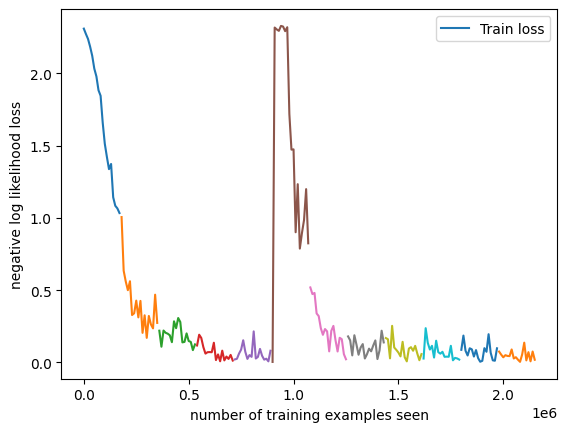

ValueError: x and y must have same first dimension, but have shapes (10,) and (34,)

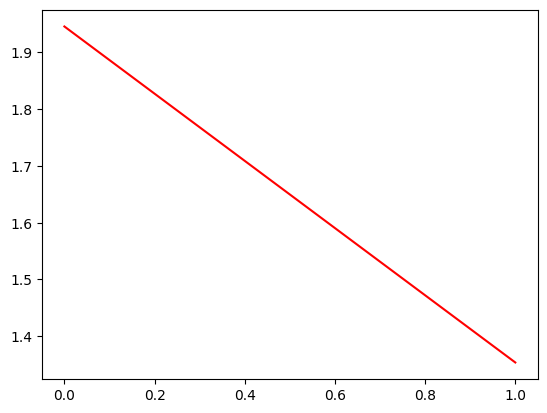

In [9]:
def draw_train_loss():
    fig = plt.figure()

    for i in range(total_epoch):
        start_index = i * len(train_counter) // total_epoch
        end_index = (i + 1) * len(train_counter) // total_epoch
        plt.plot(train_counter[start_index:end_index], train_losses[start_index:end_index])
    
    plt.legend(['Train loss'], loc='upper right')
    plt.xlabel('number of training examples seen')
    plt.ylabel('negative log likelihood loss')
    plt.show()

def draw_test_loss():
    fig = plt.figure()
    plt.plot([x / len(train_loader.dataset) for x in test_counter][:init_points], 
             test_losses[:init_points], 
             color='red', label='Test loss (Init Points)')
    plt.plot([x / len(train_loader.dataset) for x in test_counter][init_points:-1], 
             test_losses[init_points:], 
             color='blue', label='Test loss (n_iter)')
    plt.legend(['Test Loss'], loc='upper right')
    plt.xlabel('epoch')
    plt.ylabel('negative log likelihood loss')
    plt.show()

def draw_accuracy():
    fig = plt.figure()
    plt.plot([x / len(train_loader.dataset) for x in test_counter][:init_points], 
             [x.item() for x in accuracy_counter[:init_points]], 
             color='red', label='Accuracy (Init Points)')
    plt.plot([x / len(train_loader.dataset) for x in test_counter][init_points:-1], 
             [x.item() for x in accuracy_counter[init_points:]], 
             color='blue', label='Accuracy (n_iter)')
    plt.legend(loc='lower right')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.show()

draw_train_loss()
draw_test_loss()
draw_accuracy()

print("""\nbest params combo:
         learning_rate: {};
         beta1:{};
         beta2:{};
         weight_decay:{};\n
         accuracy:{}""".format(10 ** bayesian_optimizer.max["params"]["learning_rate_log"],
                               bayesian_optimizer.max["params"]["beta1"],
                               bayesian_optimizer.max["params"]["beta2"],
                               10 ** bayesian_optimizer.max["params"]["weight_decay_log"],
                               bayesian_optimizer.max["target"]))